In [1]:
!nvidia-smi

Tue Jan  5 02:40:39 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# installing tensorflow gpu

!pip install tensorflow-gpu

     |████████████████████████████████| 394.7MB 43kB/s 


In [4]:
import tensorflow as tf

tf.__version__

'2.4.0'

In [5]:
# import the required libraries

from tensorflow.keras.layers import Input, Lambda, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from glob import glob
import numpy as np

In [6]:
# resizing the input image for VGG16 requirements

image_size = [224, 224]

In [7]:
# defining dataset path

train_path = '/content/drive/MyDrive/Cotton Disease (deep learning)/train'
valid_path = '/content/drive/MyDrive/Cotton Disease (deep learning)/val'

In [8]:
# importing VGG16 architecture and using imagenet weights

vgg16 = VGG16(include_top=False, weights='imagenet', input_shape=image_size + [3])

58892288/58889256 [==============================] - 2s 0us/step


In [9]:
# checking the architecture

vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [10]:
# freezing the VGG16 pre-trained weights

for layer in vgg16.layers:
  layer.trainable = False 

In [15]:
# getting the number of output classes

folders = glob('/content/drive/MyDrive/Cotton Disease (deep learning)/train/*')

folders

['/content/drive/MyDrive/Cotton Disease (deep learning)/train/fresh cotton plant',
 '/content/drive/MyDrive/Cotton Disease (deep learning)/train/fresh cotton leaf',
 '/content/drive/MyDrive/Cotton Disease (deep learning)/train/diseased cotton plant',
 '/content/drive/MyDrive/Cotton Disease (deep learning)/train/diseased cotton leaf']

In [17]:
# number of classes

len(folders)

4

In [23]:
# flattening after the last layer of vgg16 (MaxPooling2D)(None, 7, 7, 512) )
x = Flatten()(vgg16.output)
x

<KerasTensor: shape=(None, 25088) dtype=float32 (created by layer 'flatten_3')>

In [24]:
# creating FC/Dense layers after flattening. we can have multiple of this layer

fc = Dense(units=len(folders), activation='softmax')(x)

In [27]:
print(fc)
print(vgg16.input)

KerasTensor(type_spec=TensorSpec(shape=(None, 4), dtype=tf.float32, name=None), name='dense/Softmax:0', description="created by layer 'dense'")
KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")


In [28]:
# creating the whole model: VGG16+own layers

model = Model(inputs=vgg16.input, outputs=fc)

In [29]:
# checking the whole architecture
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [30]:
# defining model performance metrics

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [34]:
# using ImageDataGenerator for data augmentation and importing images from dataset

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

validation_datagen = ImageDataGenerator(rescale = 1./255)

In [35]:
# providing target size the same as the initial image size

training_set = train_datagen.flow_from_directory('/content/drive/MyDrive/Cotton Disease (deep learning)/train',
                                                 target_size = (224,224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 1951 images belonging to 4 classes.


In [38]:
# same for test set

validation_set = validation_datagen.flow_from_directory('/content/drive/MyDrive/Cotton Disease (deep learning)/val',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 324 images belonging to 4 classes.


In [40]:
# fitting the model

model_history = model.fit(training_set,
                          validation_data = validation_set,
                          epochs = 5,
                          steps_per_epoch = len(training_set),
                          validation_steps = len(validation_set))

Epoch 1/5
61/61 [==============================] - 1032s 17s/step - loss: 0.2387 - accuracy: 0.9083 - val_loss: 0.2343 - val_accuracy: 0.9136
Epoch 2/5
61/61 [==============================] - 865s 14s/step - loss: 0.1733 - accuracy: 0.9380 - val_loss: 0.1993 - val_accuracy: 0.9290
Epoch 3/5
61/61 [==============================] - 861s 14s/step - loss: 0.1345 - accuracy: 0.9575 - val_loss: 0.1222 - val_accuracy: 0.9537
Epoch 4/5
61/61 [==============================] - 869s 14s/step - loss: 0.1047 - accuracy: 0.9692 - val_loss: 0.1891 - val_accuracy: 0.9228
Epoch 5/5
61/61 [==============================] - 878s 14s/step - loss: 0.0991 - accuracy: 0.9687 - val_loss: 0.1232 - val_accuracy: 0.9506


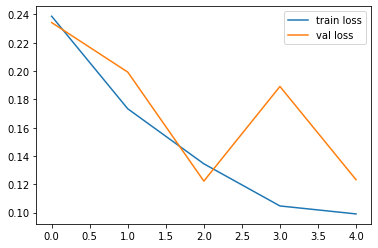

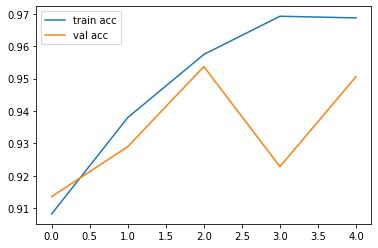

<Figure size 432x288 with 0 Axes>

In [45]:
# plot the loss
import matplotlib.pyplot as plt
plt.plot(model_history.history['loss'], label='train loss')
plt.plot(model_history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(model_history.history['accuracy'], label='train acc')
plt.plot(model_history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [47]:
# SAVING MODEL
from tensorflow.keras.models import load_model

model.save('cotton_vgg16.h5')

In [48]:
# LOADING MODEL

reloaded_model = tf.keras.models.load_model('cotton_vgg16.h5')
 
reloaded_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     